## Measure-Preserving Systems

Measure-preserving systems obey the Poincaré recurrence theorem, and are a special case of conservative systems. They provide the formal, mathematical basis for a broad range of physical systems, and, in particular, many systems from classical mechanics (in particular, most non-dissipative systems) as well as systems in thermodynamic equilibrium.

We wish to discover if there is a relationship between the dissipative element of a system and the utility of eigenvalue penalties and initialisation. That is, if we are able to capture the non-dissipative element for prediction.

### Damped Driven Pendulum

We hypothesis that as the damping increases, the utility of the penalty and initialisation will increase.

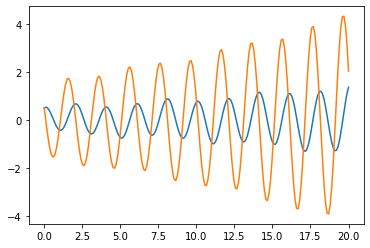

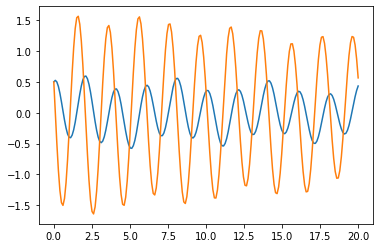

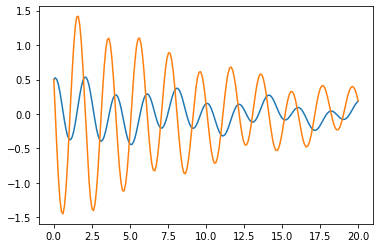

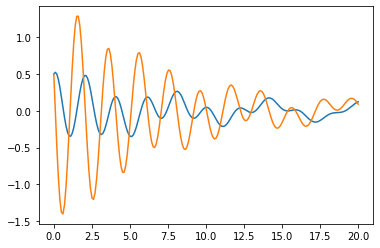

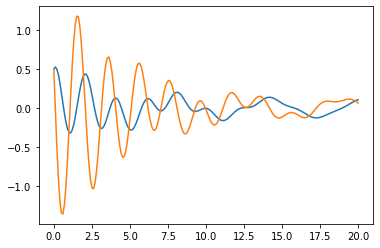

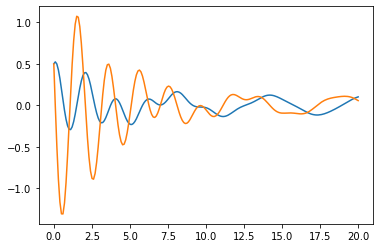

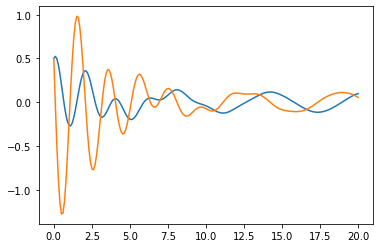

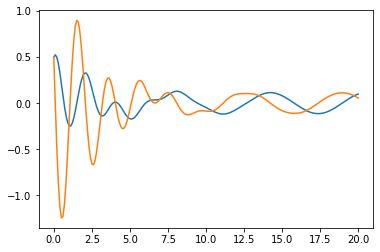

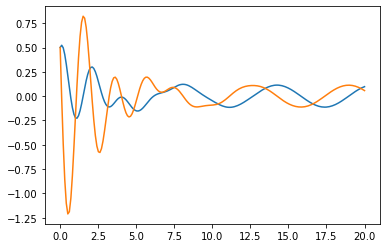

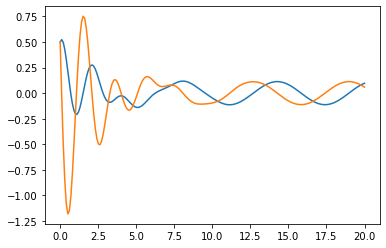

In [26]:
import scipy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import numpy as np

def simple_pendulum_deriv(x, t, m, g, l, F, c, omega): 
# The simple pendulum subject to zero damping and zero control input 
    nx = np.zeros(2)
    nx[0] = x[1]
    nx[1] = (1/m) * (F * math.sin(omega * t) - (m * g / l) * x[0] - c * nx[0])
    return nx

for c in np.linspace(-0.6, 0.6, 10):
    t_span = np.linspace(0,20,200)

    sol = odeint(simple_pendulum_deriv, y0=[0.5,0.5], t=t_span, args=(1,9.8,1,1,0.5+c,1))
    y = sol[:,0]
    y_dot = sol[:,1]
    plt.plot(t_span, y)
    plt.plot(t_span, y_dot)
    plt.show()

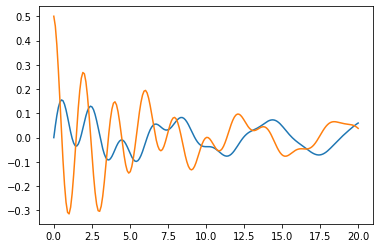

In [2]:
plt.plot(t_span, y)
plt.plot(t_span, y_dot)
plt.show()

In [110]:
ls /g/data/x77/jm0124/synthetic_datasets

base_synthesis/                 pendulum_dissipative-0.6-10.npy
gan_perturb_synthesis/          pendulum_dissipative-1.0-5.npy
normal_perturb_synthesis/       pendulum_dissipative_test.npy
pendulum_dissipative/           pendulum_dissipative_train.npy
pendulum_dissipative-0.2-5.npy  pendulum_dissipative_valid.npy
pendulum_dissipative-0.5-5.npy


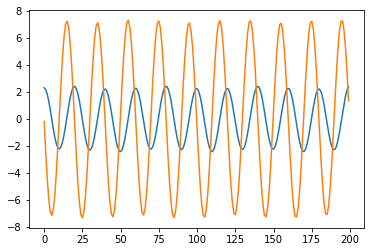

In [49]:
loaded_synth = np.load("/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative-0.6-10.npy")
plt.plot(loaded_synth[0][8640])

In [107]:
np.random.shuffle(loaded_synth)
training, val, test = loaded_synth[:,:7000], loaded_synth[:,7000:8500], loaded_synth[:,8500:10000]

In [109]:
np.save('/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative_train.npy', training)
np.save('/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative_valid.npy', val)
np.save('/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative_test.npy', test)

In [113]:
import torch
from torch.utils.data import Dataset

class PendulumToPendulum(Dataset):
    def __init__(self, prediction_length, dissipation_level, partition_name='train'):
        self.pendulum_array = np.load(f"/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative_{partition_name}.npy")
        self.dissipation_level = dissipation_level
        self.prediction_length = prediction_length
    
    def __len__(self):
        return self.pendulum_array.shape[1]
    
    def __getitem__(self, idx):
        i = 0
        for pend_run in self.pendulum_array[self.dissipation_level]:
            j = self.prediction_length
            for time_step in pend_run[self.prediction_length:-self.prediction_length]:
                if i == idx:
                    return pend_run[j-self.prediction_length:j+self.prediction_length]
                j += 1
                i += 1

In [136]:
pend_ds = PendulumToPendulum(4, 0, 'valid')

### Testing Cyclone Examples

There is a known result that if the divergence of vector fields are non-zero the system is not measure preserving.

In [25]:
import xarray
import metpy.calc
import windspharm.xarray

In [26]:
import json
train_json_path = '/g/data/x77/ob2720/partition/train.json'

with open(train_json_path, 'r') as tj:
    tj_dict = json.load(tj)

In [87]:
divs = []
for i, (cyclone, data) in enumerate(tj_dict.items()):
    if i % 250 == 0:
        cyclone_coords = tj_dict[cyclone]['coordinates']
        ds = xarray.open_mfdataset(f"/g/data/x77/ob2720/partition/train/{cyclone}.nc")
        u = ds.u[dict(time=int(len(ds.time)/2), level=2)]
        v = ds.v[dict(time=int(len(ds.time)/2), level=2)]
        new_lat = u.latitude/4 + cyclone_coords[int(len(ds.time)/2)][1] - 20
        new_lon = u.longitude/4 + cyclone_coords[int(len(ds.time)/2)][0] - 20
        dx, dy = metpy.calc.lat_lon_grid_deltas(longitude=new_lon.values, latitude=new_lat.values)
        div = metpy.calc.divergence(u, v, dx=dx, dy=dy)
        divs.append(div.values * 10800)

<AxesSubplot:>

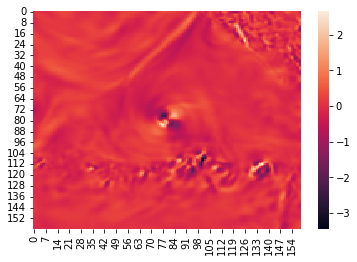

In [114]:
seaborn.heatmap(divs[1])

In [107]:
divs[0].sum()

197.70461062260736

Here, we have shown that over the 3h timescale of prediction used, the divergence of the system is clearly non-zero for a random selection of cyclone examples.